In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt 

seed = 25

# Descrição do conjunto de dados

Pegarei os dados diretamente do site. Estaremos atrás de prever o valor médio de casas em Boston, dados os outros dados. 

In [2]:
variaveis = ['CRIM','ZN', 'INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']

boston_inicial = pd.read_csv("http://lib.stat.cmu.edu/datasets/boston", sep="\s+", skiprows=22,header = None)
boston_np = np.hstack([boston_inicial.values[::2, :], boston_inicial.values[1::2, :3]])

boston = pd.DataFrame(boston_np, columns = variaveis)

boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Separação do conjunto em treino e teste

Farei uma divisão estratificada do conjunto de treino do conjunto de testes, primeiro estratificando em cinco partes os valores em MEDV.

In [3]:
boston["CAT"] = pd.cut(boston["MEDV"], bins=[4., 14, 23, 32, 41., np.inf], labels=[1, 2, 3, 4, 5])

Escolhi aquela divisão tendo em mente o menor  e o maior valor alcançado por MEDV, de 5 e 50.

Utilizamos então o scikitlearn para fazer a divisão estratificada dos conjuntos de treino e teste.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, test_index in split.split(boston, boston["CAT"]):
    strat_train_set = boston.loc[train_index]
    strat_test_set = boston.loc[test_index]

X_train = strat_train_set.iloc[:, 0:-2].values
y_train = strat_train_set.iloc[:, -2].values
X_test = strat_test_set.iloc[:, 0:-2].values
y_test = strat_test_set.iloc[:, -2].values

# Visualização do conjunto de dados

Faremos então uma pequena visualização dos dados no conjunto de treino, não observando o conjunto de teste para evitar o snooping bias.

Primeiro podemos observar o boxplot dos valores médios dos preços das moradias.

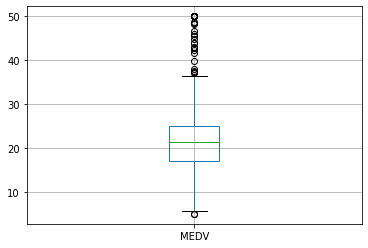

In [5]:
strat_train_set.boxplot(column=['MEDV'])

Podemos notar que há vários outliers com preços maiores, e um tanto altos, mas que provavelmente ainda são necessários para o modelo, já que realmente é de se imaginar que em certas condições moradias estejam bastante mais caras. 

Agora vamos observar as correlações dos dados, em especial a dos dados com MEDV, que é o que estaremos procurando prever.

In [6]:
strat_train_set.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.199656,0.392855,-0.064536,0.409702,-0.197596,0.336103,-0.368621,0.609365,0.564401,0.288899,-0.358299,0.457047,-0.390775
ZN,-0.199656,1.000000,-0.553904,-0.047928,-0.521554,0.338518,-0.576966,0.665436,-0.318505,-0.336607,-0.425063,0.183352,-0.431892,0.388177
INDUS,0.392855,-0.553904,1.000000,0.053176,0.768120,-0.414912,0.639632,-0.710356,0.590519,0.743644,0.396426,-0.366869,0.613495,-0.513447
CHAS,-0.064536,-0.047928,0.053176,1.000000,0.059178,0.095982,0.086318,-0.089437,-0.041652,-0.069132,-0.145027,0.042393,-0.055707,0.170628
NOX,0.409702,-0.521554,0.768120,0.059178,1.000000,-0.310320,0.728792,-0.770819,0.599533,0.667075,0.198915,-0.416671,0.583929,-0.441316
RM,-0.197596,0.338518,-0.414912,0.095982,-0.310320,1.000000,-0.254780,0.223140,-0.207169,-0.303786,-0.355797,0.131156,-0.618409,0.682386
AGE,0.336103,-0.576966,0.639632,0.086318,0.728792,-0.254780,1.000000,-0.744412,0.446674,0.503030,0.264788,-0.275374,0.593842,-0.386046
DIS,-0.368621,0.665436,-0.710356,-0.089437,-0.770819,0.223140,-0.744412,1.000000,-0.488622,-0.541647,-0.251970,0.297934,-0.507297,0.270125
RAD,0.609365,-0.318505,0.590519,-0.041652,0.599533,-0.207169,0.446674,-0.488622,1.000000,0.903714,0.478470,-0.442392,0.474886,-0.386375
TAX,0.564401,-0.336607,0.743644,-0.069132,0.667075,-0.303786,0.503030,-0.541647,0.903714,1.000000,0.480082,-0.443552,0.540873,-0.486922


In [7]:
strat_train_set.corr()["MEDV"].sort_values()

LSTAT     -0.739697
INDUS     -0.513447
PTRATIO   -0.505325
TAX       -0.486922
NOX       -0.441316
CRIM      -0.390775
RAD       -0.386375
AGE       -0.386046
CHAS       0.170628
DIS        0.270125
B          0.344094
ZN         0.388177
RM         0.682386
MEDV       1.000000
Name: MEDV, dtype: float64

Vemos que a quantidade média de quartos por moradia possui a maior correlação. Faz sentido que MEDV tenha uma correlação alta com RM, já que uma quantidade maior de quartos no geral deve estar bem relacionada com o tamanho da moradia, que deve afetar bastante o preço.

Podemos pegar alguns dados interessantes para verificar os scatter plots com MEDV e entre si.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49b435fcd0>,
      dtype=object)

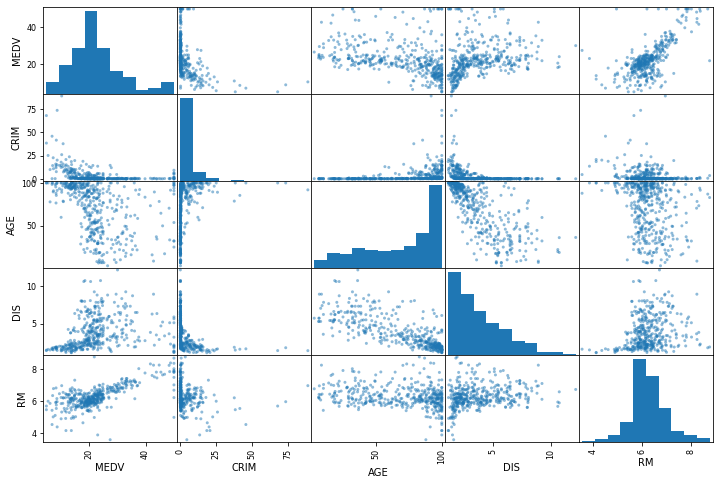

In [8]:
from pandas.plotting import scatter_matrix

scatter_matrix(strat_train_set[["MEDV","CRIM","AGE","DIS","RM"]], figsize=(12, 8))

Podemos notar algumas coisas interessantes, como que a taxa de criminalidade parece abaixar o preço quando é maior, mas uma taxa de criminalidade pequena não o afeta tanto.

No gráfico de RM por MEDV vemos uma correlação decente entre os dados em sua maioria, mas vemos também alguns dados um tanto fora de lugar, como os alinhados no topo no valor médio de 50000.

Inclusive, vemos valores alinhados no topo nas quatro scatter plots com o MEDV, provavelmente devido à censura mencionada no site que disponibiliza o dataset.

# Preparação do conjunto de dados

Vemos primeiramente que não há problemas com os dados, de modo que não há mais o que ajustar neste quesito.

In [9]:
sample_incomplete_rows = strat_train_set[strat_train_set.isnull().any(axis=1)].head() 
sample_incomplete_rows

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT


Fazemos então um ajuste para que os dados fiquem normalizados, os escalando separadamente para evitar o data leakage, já que caso normalizassemos o dataset todo de uma vez e assim o separássemos, estariamos de certo modo dando informação do nosso conjunto de teste para nosso conjunto de treino.

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Com isto, não há mais muito o que se preparar, e podemos aplicar os modelos.



# Comparação de modelos

Compararemos assim três modelos, o Linear Regression, o KNN e a Random Forest.

Testaremos o KNN com três parâmetros diferentes e a Random Forest com dois, como seguirão.

Para fazer a validação dos modelos, utilizarei o cross validation

Primeiramente os colocarei numa lista para testar todos de uma vez.

In [11]:
modelos = []

In [12]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

modelos.append(lin_reg)

In [13]:
from sklearn.neighbors import KNeighborsRegressor

knn1 = KNeighborsRegressor(n_neighbors = 2)
knn2 = KNeighborsRegressor(n_neighbors = 5)
knn3 = KNeighborsRegressor(n_neighbors = 8)

modelos.append(knn1)
modelos.append(knn2)
modelos.append(knn3)

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf1 = RandomForestRegressor(n_estimators=100, random_state = seed, max_depth = 5)
rf2 = RandomForestRegressor(n_estimators=100, random_state = seed, max_depth = 20)

modelos.append(rf1)
modelos.append(rf2)

In [15]:
from sklearn.model_selection import cross_val_score

for i in modelos:
  score = cross_val_score(i, X_train, y_train, scoring="neg_mean_squared_error",cv=10)
  raiz = np.sqrt(-score)
  print(raiz.mean())

4.872569501996919
4.710261224978389
4.845294850216283
5.118350828100121
3.672982061491935
3.45366688032789


Estou utilizando o erro quadrático médio para verificação de qual modelo está se dando melhor, pois imagino que para este problema seja de maior interesse que punamos mais os erros maiores, ao invés de pedir que a maioria dos dados esteja o mais próximo possível de seu valor verdadeiro, já que ocorrer um erro imenso na previsão de um preço pode ser de maior irritação para o interessado que ocorrer alguns erros medianos.

Vemos com a cross-validation que o modelo rf2 possui o menor erro médio nos testes no próprio conjunto de testes. Mas será que ele não está um pouco propenso a overfitting? Veremos como os modelos atuam treinados e aplicados no próprio conjunto de treino;

In [16]:
from sklearn.metrics import mean_squared_error as MSE

for i in modelos:
  i.fit(X_train, y_train)
  treinoprevisao = i.predict(X_train)
  treino = MSE(y_train, treinoprevisao)
  print(np.sqrt(treino))

4.744572961499924
2.4705167415536837
3.9917046409515398
4.580825000885498
2.265361437269201
1.3091357217952906


Vemos que o erro quadrático médio de rf2 treinado e aplicado no conjunto de treino é bastante pequeno, em comparação com o resultado da cross-validation do mesmo, que pode indicar um overfitting. rf1, por outro lado, que possuia o segundo menor erro dado pela cross-validation, possui um erro um pouco mais próximo do erro dado pela cross-validation, de modo que não parece estar tão overfit quanto rf2.

Faz sentido que rf2 esteja mais overfit que rf1, já que rf2 possui árvores com mais branches, mas como esta diferença é deveras maior, imagino que devemos decidir escolher rf1 como o melhor modelo.

# Teste final

In [17]:
rf1.fit(X_train, y_train)
previsao = rf1.predict(X_test)

resultado = MSE(y_test, previsao)
print(np.sqrt(resultado))

3.408011400362232
